In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, clear_output
from idlescape import *
from ipydatagrid import DataGrid
try:
    from ipywidgets import interact, widgets
except ImportError:
    %pip install ipywidgets
    from ipywidgets import interact, widgets

locationFile = "data/locations.json"
itemFile = "data/items.json"
player = Character(
    datafile=itemFile,
    fishing_level=90,
    fishing_bonus=60,
    fishing_set_bonus=0.4,
    bait_power=55.5,
    reel_power=47+15,
    bonus_rarity=90,
    mining_level=86,
    mining_set_bonus=0.25,
    mining_bonus=59,
    foraging_level=82,
    foraging_bonus=59,
    foraging_set_bonus=0.25,
    )
fishing = Fishing(player, locationFile);
mining = Mining(player, locationFile);
foraging = Foraging(player, locationFile);

#player.enchantments['gathering'] = 5
player.enchantments['nature'] = 3
player.enchantments['herbalist'] = 3
player.enchantments['seedHarvesting'] = 3

In [10]:
class InteractiveCharacter:
    def __init__(self, item_file, location_file, **kwargs):
        self.player_stats = kwargs.get("player_stats", dict())
        self.player = Character(datafile=item_file, *(self.player_stats))
        self.mining = Mining(self.player, location_file)
        self.foraging = Foraging(self.player, location_file)
        self.fishing = Fishing(self.player, location_file)
        
    def setup_display(self):
        interact(lambda x: setattr( self.player, 'fishing_level', x ), 
                 x=widgets.IntSlider(min=1, max=200, value=self.player.fishing_level, description='Fishing Level'))
        interact(lambda x: setattr( self.player, 'mining_level', x ), 
                 x=widgets.IntSlider(min=1, max=200, value=self.player.mining_level, description='Mining Level'))
        interact(lambda x: setattr( self.player, 'foraging_level', x ), 
                 x=widgets.IntSlider(min=1, max=200, value=self.player.foraging_level, description='Foraging Level'))
        
Chikenz = InteractiveCharacter(itemFile, locationFile)
Chikenz.setup_display()

interactive(children=(IntSlider(value=1, description='Fishing Level', max=200, min=1), Output()), _dom_classes…

interactive(children=(IntSlider(value=1, description='Mining Level', max=200, min=1), Output()), _dom_classes=…

interactive(children=(IntSlider(value=1, description='Foraging Level', max=200, min=1), Output()), _dom_classe…

In [11]:
def zone_summary(action, zone, **kwargs):
    draw = kwargs.get("draw", True)
    item_series = action.location_item_histogram(zone, interval='hour').round(1)
    if not draw:
        return item_series
    fig_size = (16, 6)
    if( item_series.sum() > 0 ):
        fig, axs = plt.subplots(1,2, figsize=(16,6))
        axs[0].set_title(zone)
        item_series[item_series.gt(0)].plot.pie(ax=axs[0])
        ax = item_series.plot.bar(ax=axs[1])
        ax.grid(axis='y')
        axs[1].bar_label(axs[1].containers[0])
    return item_series
        
def action_summary(action, **kwargs):
    series_list = []
    indices = action.list_of_actions()
    for action_name in indices:
        series_list.append(zone_summary(action, action_name))
    df = pd.DataFrame(series_list, index=indices).fillna(0)
    return df

craft_xp = {"Log": 5, "Oak Log": 10, "Willow Log": 15, "Maple Log": 30, "Yew Log": 45, "Elder Log": 100, 
            "Raw Tentacle Meat": 150, "Rotten Driftwood": 30, "Sturdy Driftwood": 70,
            "Aqueous Grass": 1, "Water Weeds": 3, "River Vines": 6, "Violet Ribbons": 9, "White Reeds": 16, "Ancient Kelp": 20,
            "Stygian Ore": 10}
# Fish oil
for (k, v) in player.item_data.items():
    if "fish" in v.get("tags",[]):
        crafting_xp = 50 * v.get("size",0)/20
        craft_xp[v["name"]] = crafting_xp

def craft_summary(from_action_summary):
    sub_series = []
    for (k, v) in craft_xp.items():
        if k in from_action_summary:
            sub_series.append( (from_action_summary[k] * v ) )
    return pd.concat(sub_series, axis=1).sum(1)
#z = action_summary(Chikenz.mining)

In [12]:
def action_balance_widget(action, **kwargs):
    location_choice = kwargs.get("location", action.locations.keys())
    min_range = kwargs.get("min_range", -150)
    max_range = kwargs.get("max_range", 200)
    if type(location_choice) is not list:
        location_choice = [location_choice]
    for loc_name in location_choice:
        location = action.locations[loc_name]
        widget_list = {}
        for ( node_name, node) in location.nodes.items():
            display( node_name )
            next_widget=widgets.FloatRangeSlider(value=[node.frequency, node.max_frequency], 
                                                 min=min_range, max=max_range)
            widget_list[node_name] = next_widget
        def update_func( **values ):
            for (k, v) in values.items():
                action.locations[loc_name].nodes[k].frequency = v[0]
                action.locations[loc_name].nodes[k].max_frequency = v[1]
            zone_summary(action, loc_name)
        interact(update_func, **widget_list)

action_balance_widget(foraging, location='Living Forest', min_range=-5, max_range=25)
#zone_summary(fishing, 'Shallow Pond')

'The Living Forest'

'Healthy Living'

'The Young Trees'

'The Elder Tree'

'Living Reagents'

'Living Seeds'

interactive(children=(FloatRangeSlider(value=(3.0, 3.0), description='The Living Forest', max=25.0, min=-5.0),…

In [13]:
def create_table_from_nodelist(action, zone, node):
    this_node = action.locations[zone].nodes[node]
    #sheet = ipysheet.sheet(rows=len(this_node.loot)+1, columns=5)
    data_dict = { "Name":[], "frequency":[], "maxFrequency":[], "minAmount":[], "maxAmount":[] }
    for (item_id, loot) in this_node.loot.items():
        name = action.player.item_data[str(item_id)]['name']
        data_dict["Name"].append(name)
        data_dict["frequency"].append(loot.frequency)
        data_dict["maxFrequency"].append(loot.max_frequency)
        data_dict["minAmount"].append(loot.min_amount)
        data_dict["maxAmount"].append(loot.max_amount)
        print(name, loot.frequency, loot.max_frequency, loot.min_amount, loot.max_amount)
    df = pd.DataFrame(data_dict) #.drop("index", axis=1)
    dgrid = DataGrid(df)
    return dgrid

create_table_from_nodelist(fishing, 'Stormy Seas', 'The Stormy Seas')

Raw Tuna 25 50 1 1
Raw Shark 50 75 1 1
Raw Hammerhead Shark 15 50 1 1
Raw Great White Shark -10 10 1 1
Raw Huge Tuna -25 25 1 1
Raw Megalodon -50 5 1 1
Seaweed 1 10 1 1
Aqueous Grass 1 5 1 5
Water Weeds 1 5 1 5
River Vines 1 5 1 5
Violet Ribbons 1 5 1 5
White Reeds -5 5 1 5
Rotten Driftwood 1 20 1 1
Sturdy Driftwood 1 20 1 1
Aquamarine -45 1.5 1 1
Mystical Driftwood -35 8 1 1


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

Grasslands        3148.0
Verdant Valley    3802.0
Fungal Grotto     2715.0
The Tangle        8190.0
Misty Marsh       6395.0
Frozen Tundra     6336.0
Haunted Woods     6624.0
Living Forest     9863.0
dtype: float64

,Carrot Seed,Honey,Carrot,Potato,Potato Seed,Wildberry,Wildberry Bush Seed,Branch,Log,Glowbug Bait,...,Snow,Yew Tree Seed,Yew Log,Mandrake,Black Berry,Fairy Dust,Lotus Flower,Durian,Elder Log,Elder Tree Seed
Grasslands,46.2,31.5,30.3,30.3,38.9,74.6,39.6,1302.8,629.6,55.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Verdant Valley,20.8,94.4,16.8,0.0,0.0,0.0,0.0,795.0,262.8,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fungal Grotto,44.7,0.0,123.8,123.8,44.7,0.0,0.0,222.8,90.5,21.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Tangle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,136.5,136.5,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Misty Marsh,0.0,0.0,0.0,28.2,31.7,0.0,0.0,0.0,0.0,1.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Frozen Tundra,0.0,0.0,0.0,0.0,0.0,70.4,17.6,0.0,0.0,0.0,...,0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Haunted Woods,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,21.5,49.1,29.1,29.1,29.1,0.0,0.0,0.0,0.0
Living Forest,0.0,17.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.6,48.5,0.0,0.0,32.3,32.3,32.3,29.9,0.7


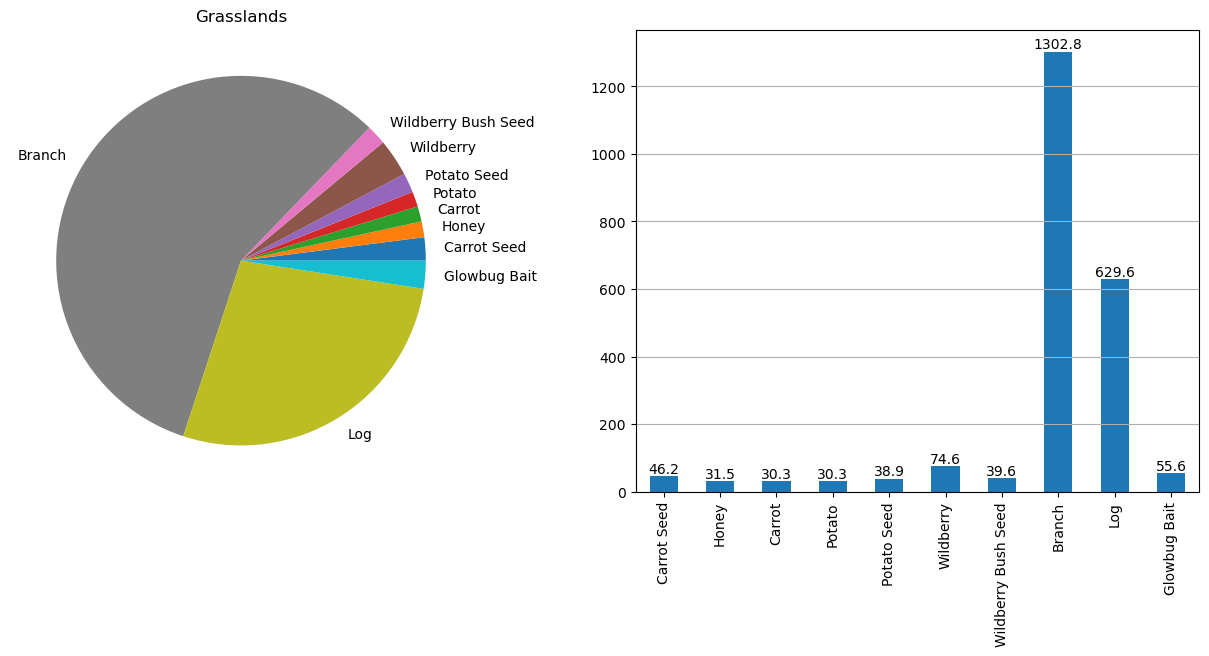

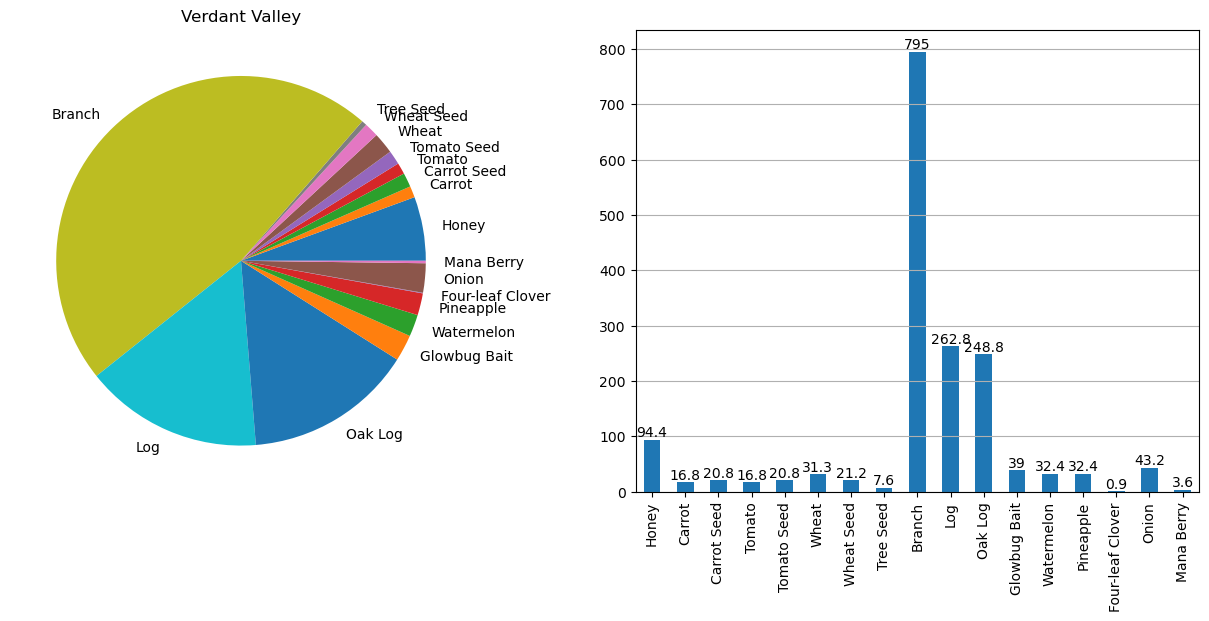

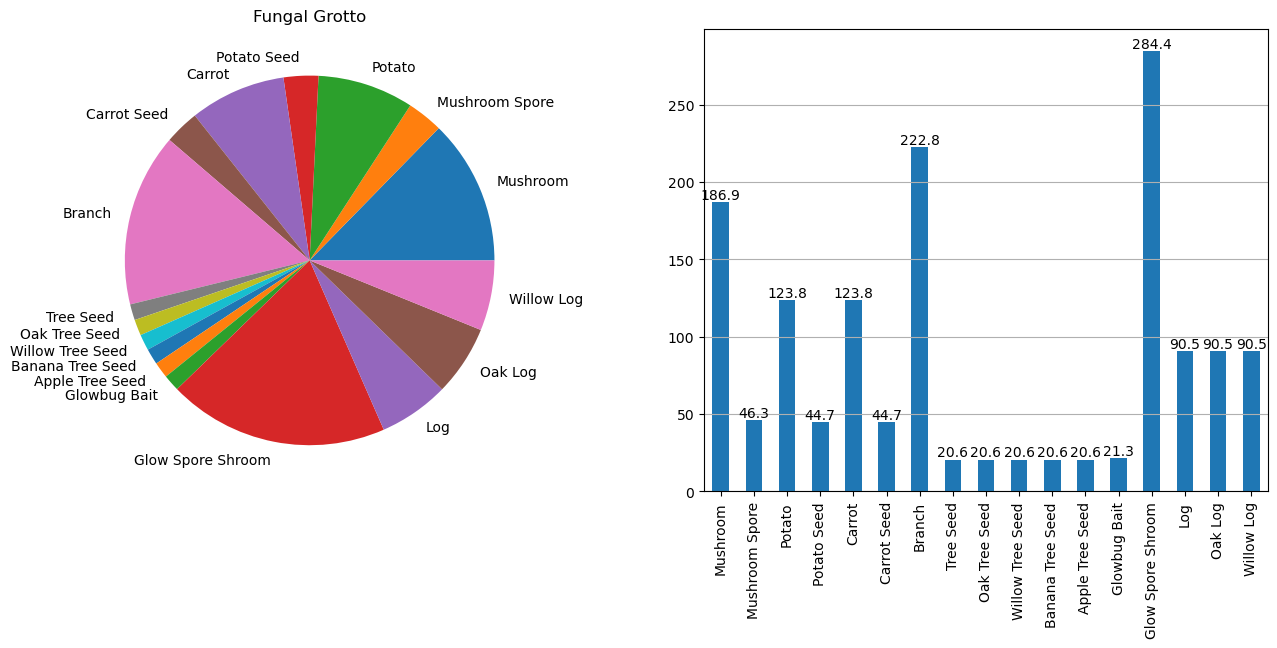

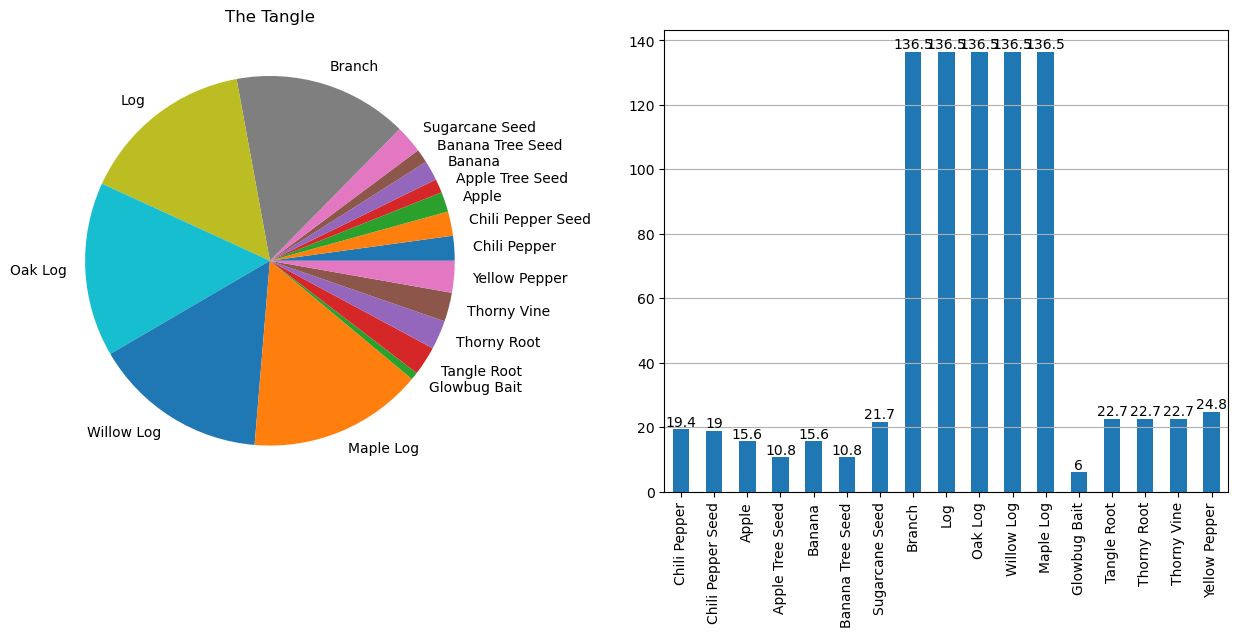

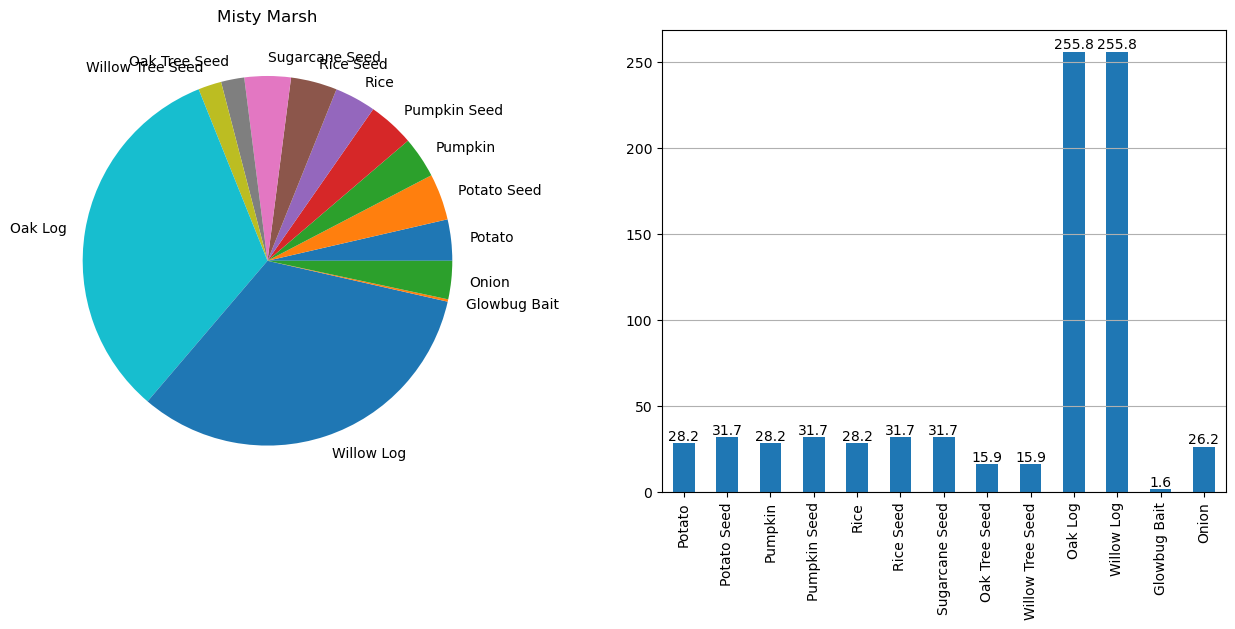

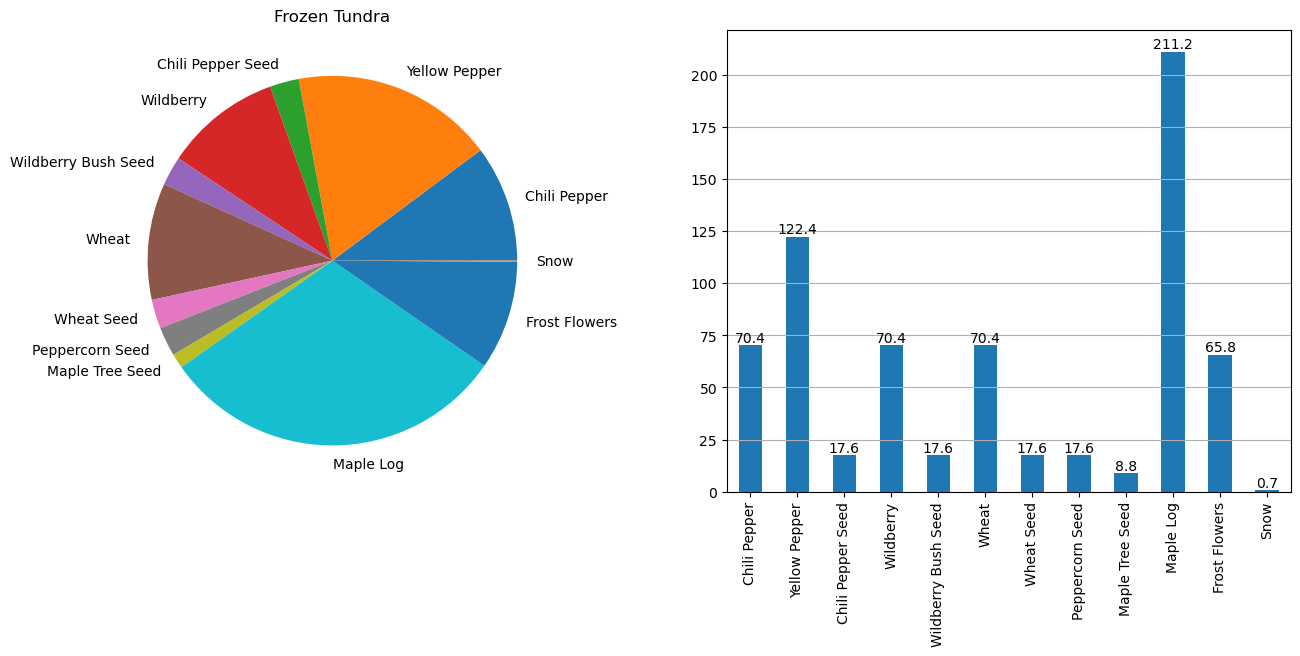

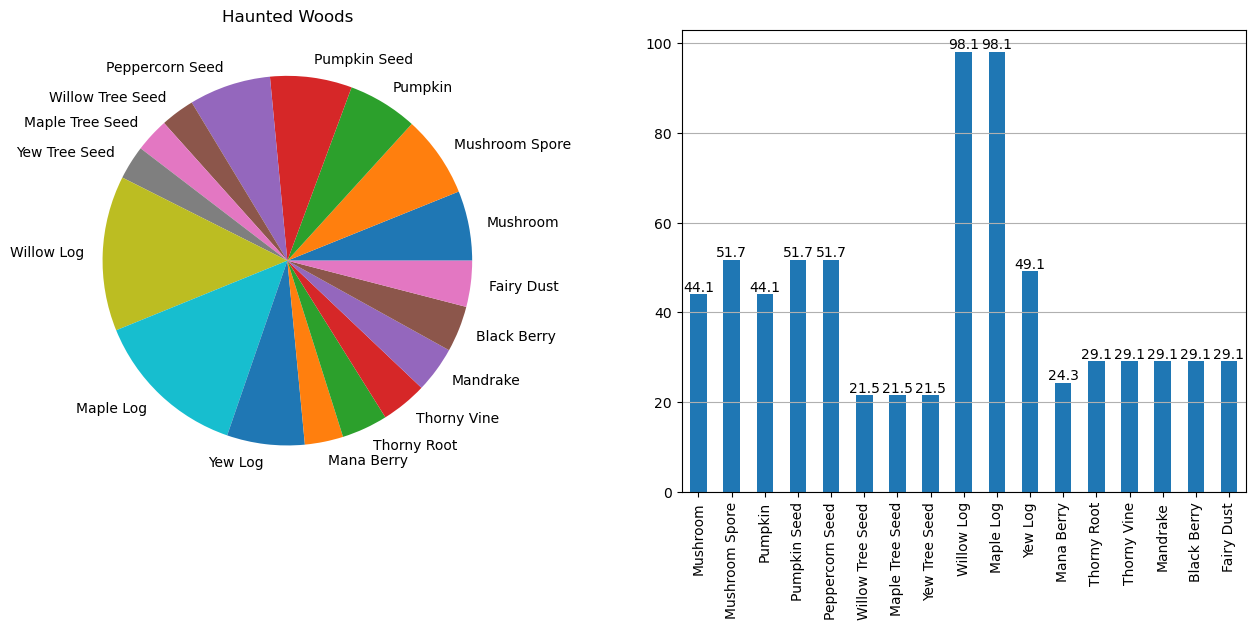

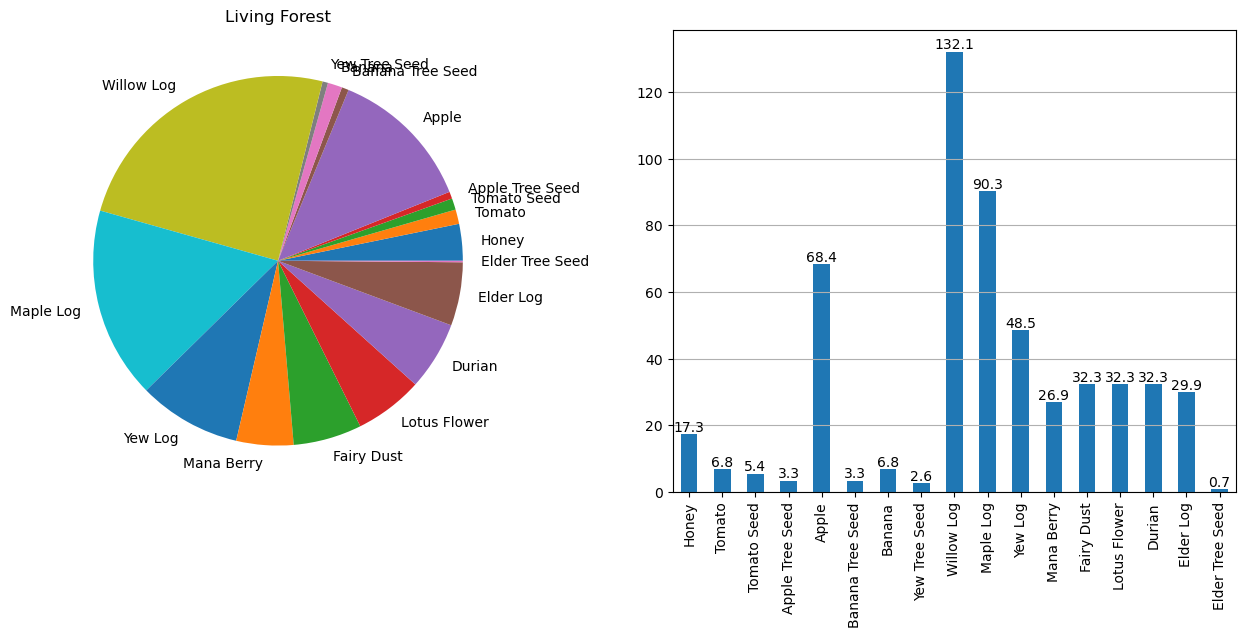

In [14]:
forage = action_summary(foraging)
display(craft_summary(forage))
display(forage)

Shallow Pond     3399.90
Lazy River       5985.00
Still Lake       6189.60
Open Ocean      11087.55
Stormy Seas     16038.00
dtype: float64

,Raw Shrimp,Raw Anchovy,Raw Magnetic Minnow,Seaweed,Aqueous Grass,Rotten Driftwood,Water Weeds,Raw Trout,Raw Salmon,Raw Tigerfish,...,Raw Tuna,Raw Shark,Raw Hammerhead Shark,Raw Great White Shark,Raw Huge Tuna,Raw Megalodon,Raw Tentacle Meat,Mystical Driftwood,White Reeds,Ancient Kelp
Shallow Pond,359.4,237.5,40.1,82.9,97.1,53.3,37.1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lazy River,0.0,0.0,39.7,38.2,67.6,42.5,97.0,224.1,204.5,70.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Still Lake,0.0,0.0,15.9,23.1,40.3,17.3,37.5,0.0,0.0,44.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Open Ocean,0.0,0.0,0.0,26.6,26.6,27.8,26.6,0.0,0.0,0.0,...,112.5,121.6,80.7,54.9,72.7,40.2,15.1,7.3,10.0,0.0
Stormy Seas,0.0,0.0,0.0,50.3,26.0,47.4,26.0,0.0,0.0,0.0,...,106.0,105.3,64.8,22.0,43.0,26.1,34.7,13.2,26.0,23.9


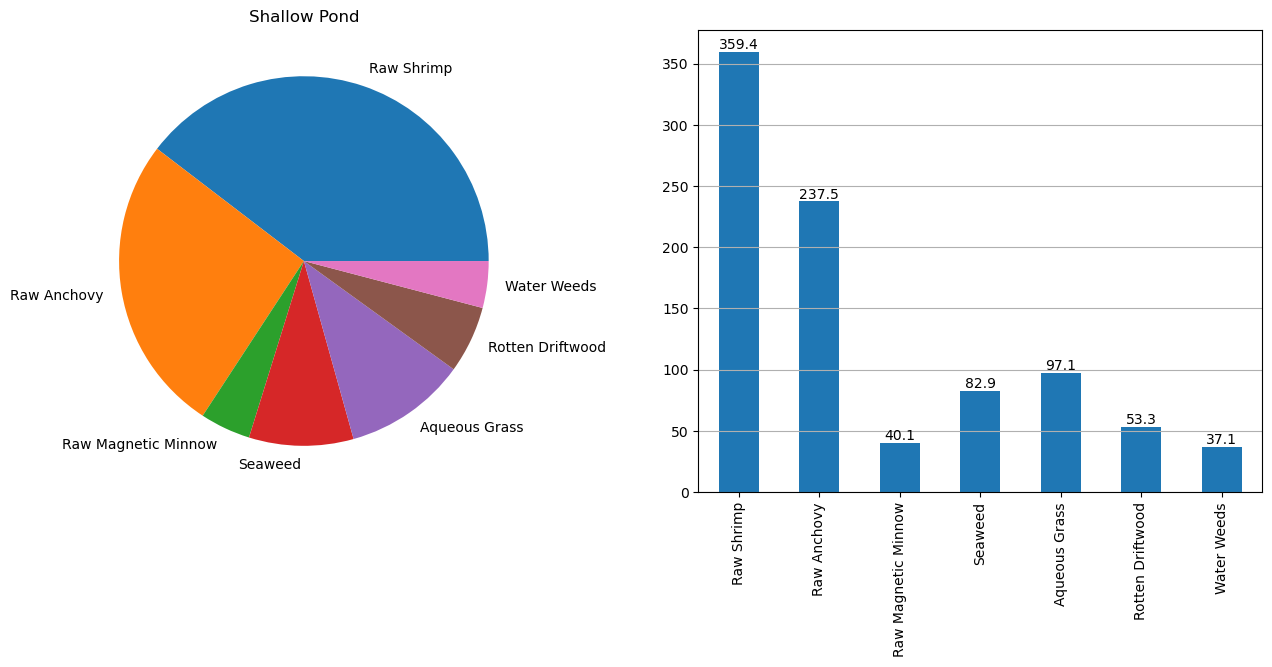

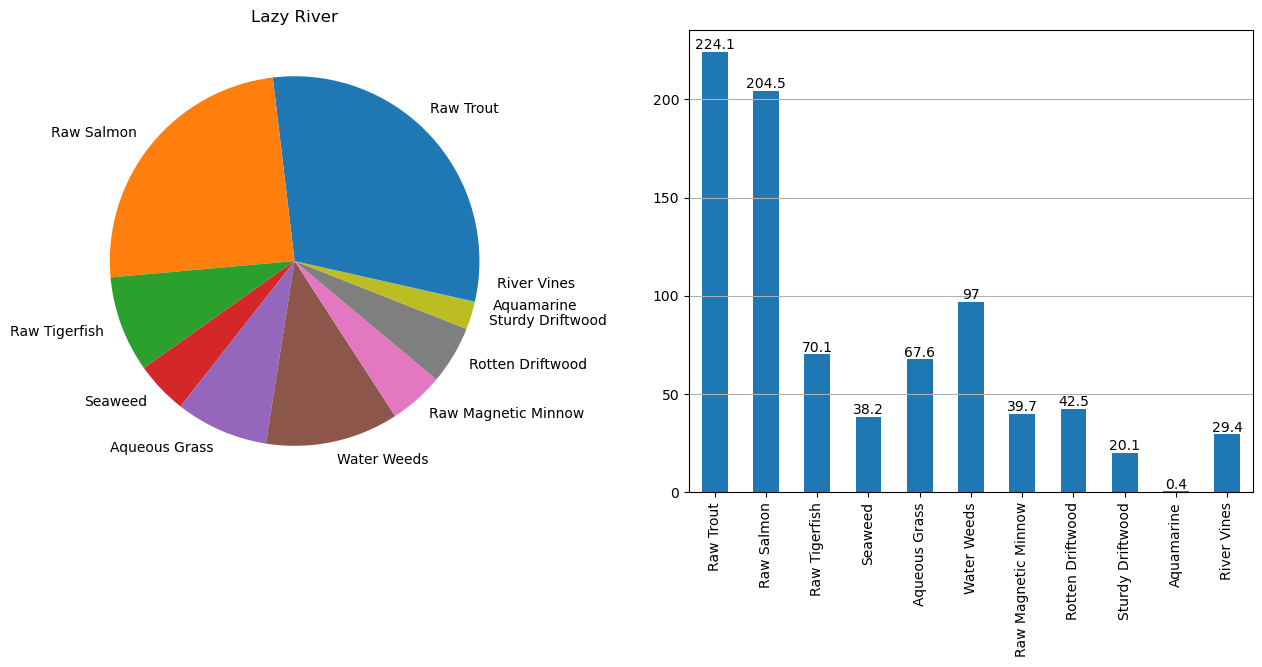

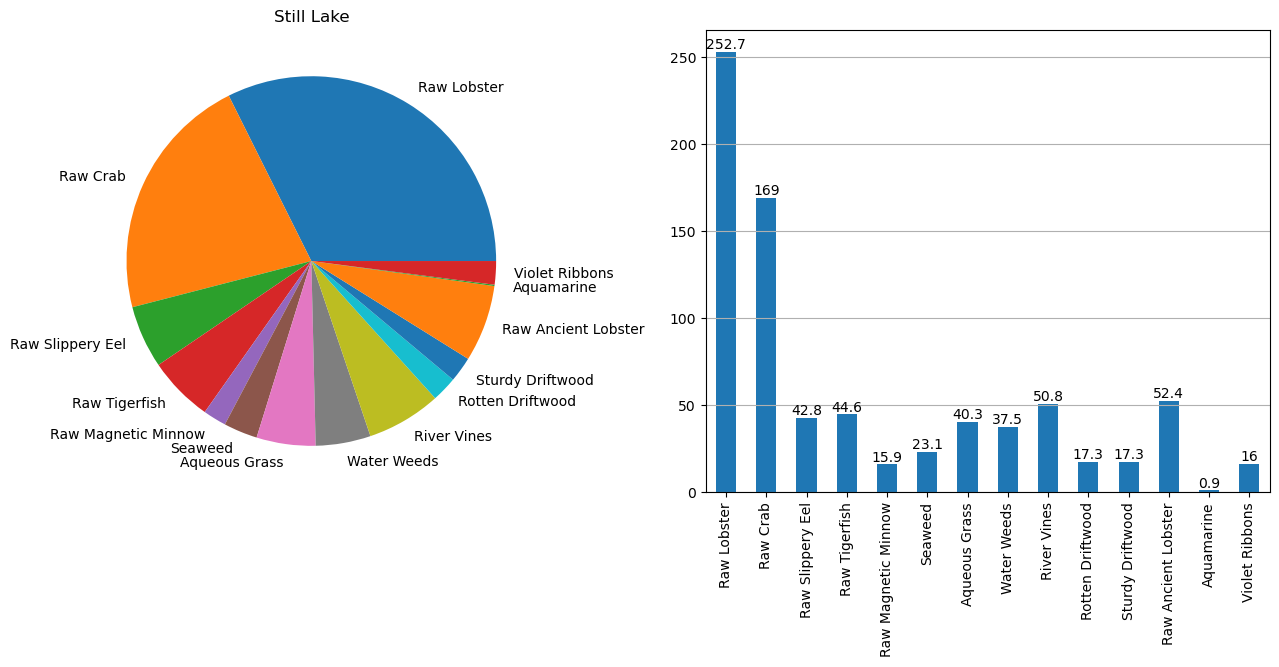

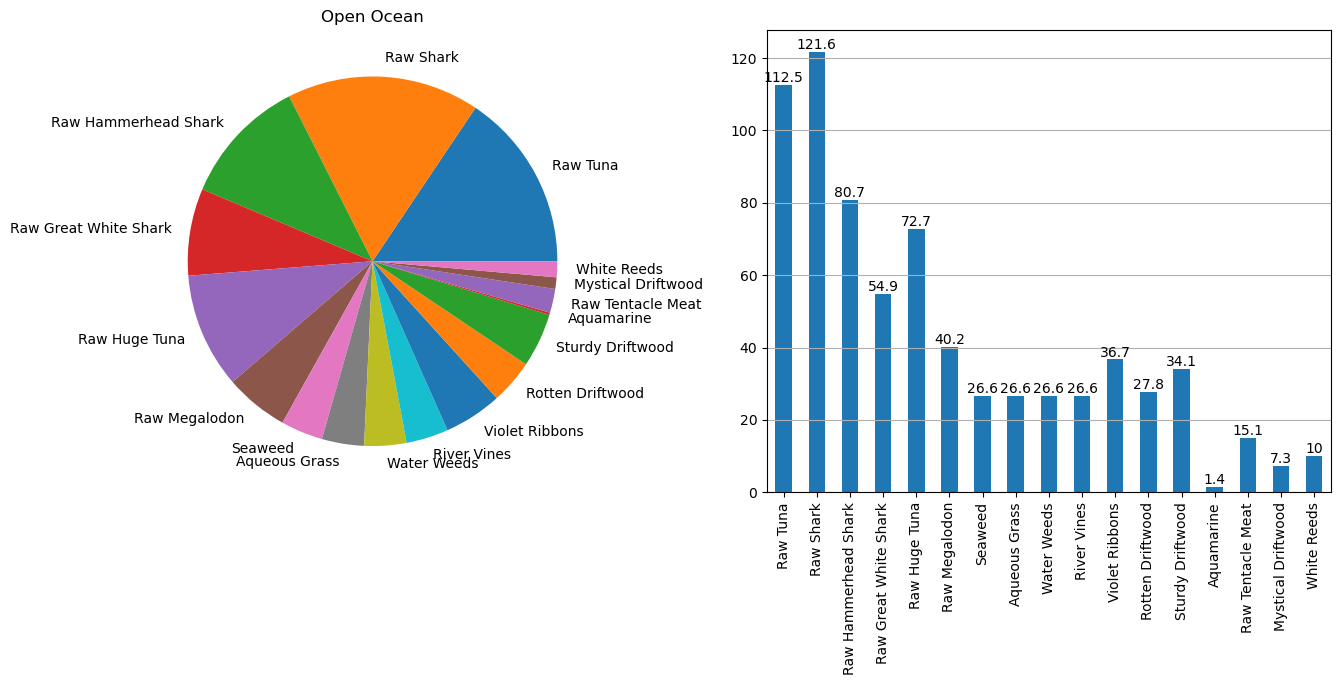

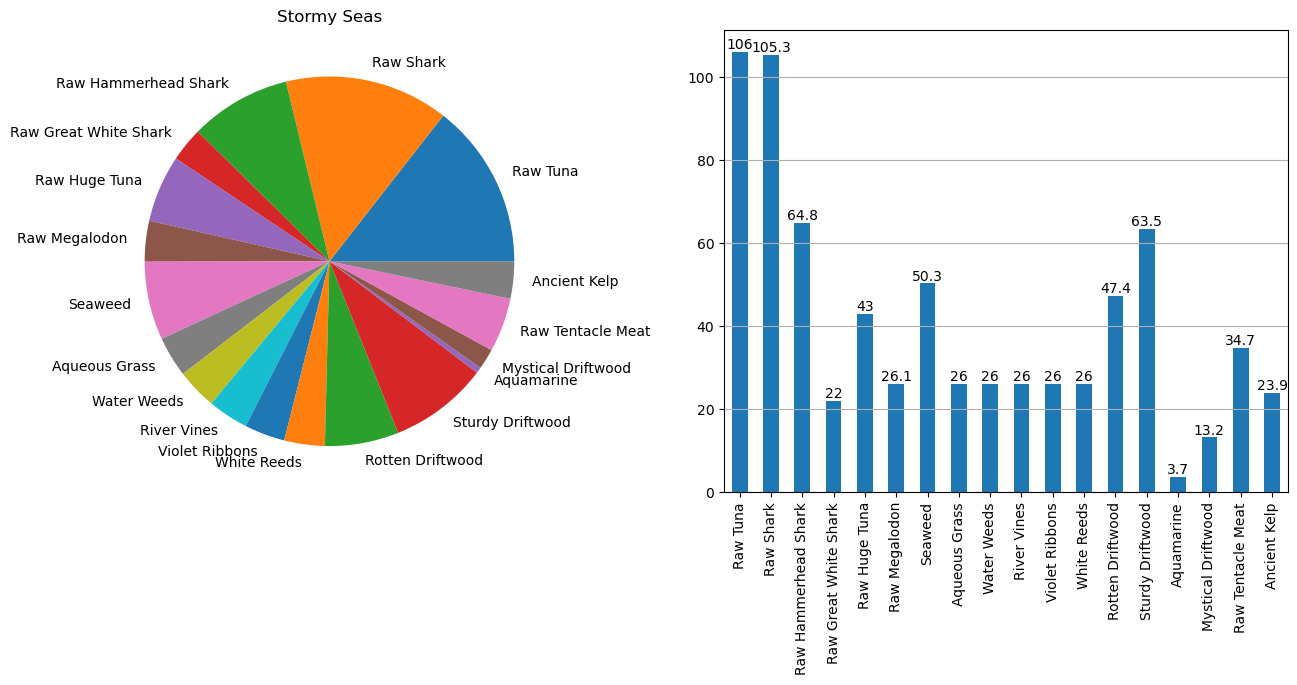

In [15]:
fishy = action_summary(fishing)
display(craft_summary(fishy))
display(fishy)

Clay Pit                 0.0
City Outskirts Mine      0.0
Village Quarry           0.0
Desert Mine              0.0
Underground Mine         0.0
Hidden Mine              0.0
Volcano Mine             0.0
Slate Spires             0.0
Deep Pit               699.0
dtype: float64

,Clay,Copper Ore,Tin Ore,Stone,Sand,Fat Nightcrawler Bait,Iron Ore,Coal,Mithril Ore,Silver,Salt,Rune Slate,Gold Ore,Adamantite Ore,Runite Ore,Stygian Ore,Void Stone
Clay Pit,737.8,368.9,368.9,184.5,276.7,18.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
City Outskirts Mine,230.6,345.9,345.9,230.6,230.6,11.5,57.6,57.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Village Quarry,0.0,0.0,0.0,720.5,0.0,11.5,576.4,432.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Desert Mine,33.0,0.0,0.0,0.0,366.2,0.0,65.9,73.2,146.5,146.5,73.2,65.9,36.6,0.0,0.0,0.0,0.0
Underground Mine,0.0,0.0,0.0,77.6,0.0,0.0,38.8,38.8,232.9,97.0,155.2,116.4,135.8,0.0,0.0,0.0,0.0
Hidden Mine,0.0,0.0,0.0,93.2,0.0,0.0,0.0,0.0,62.1,124.2,0.0,62.1,62.1,217.4,31.0,0.0,0.0
Volcano Mine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,124.2,124.2,0.0,62.1,62.1,124.2,124.2,0.0,0.0
Slate Spires,0.0,0.0,0.0,285.2,285.2,0.0,0.0,0.0,0.0,0.0,0.0,2376.3,0.0,0.0,0.0,0.0,0.0
Deep Pit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.9,104.8,0.0,232.9,69.9,23.3


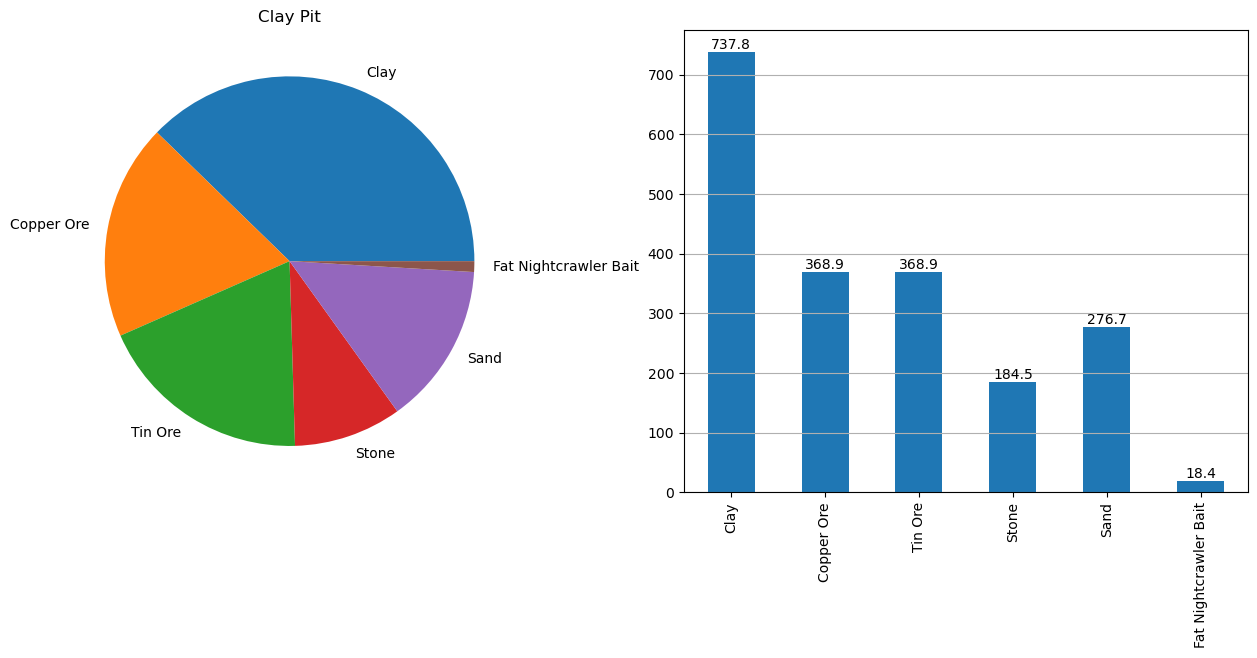

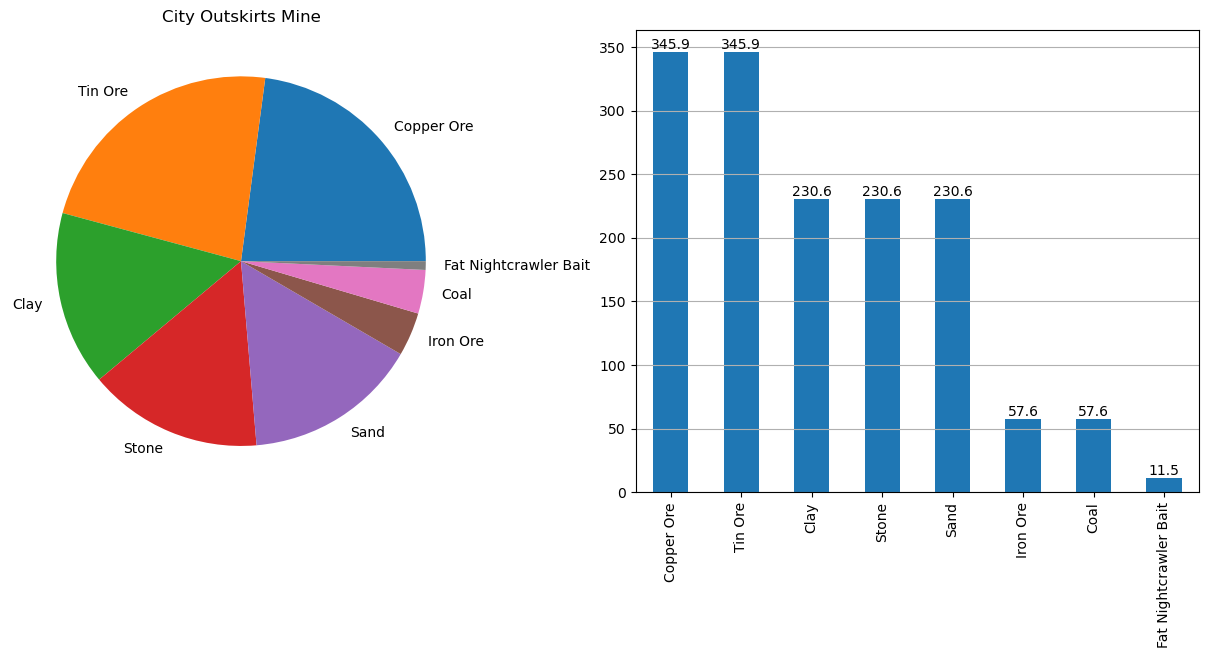

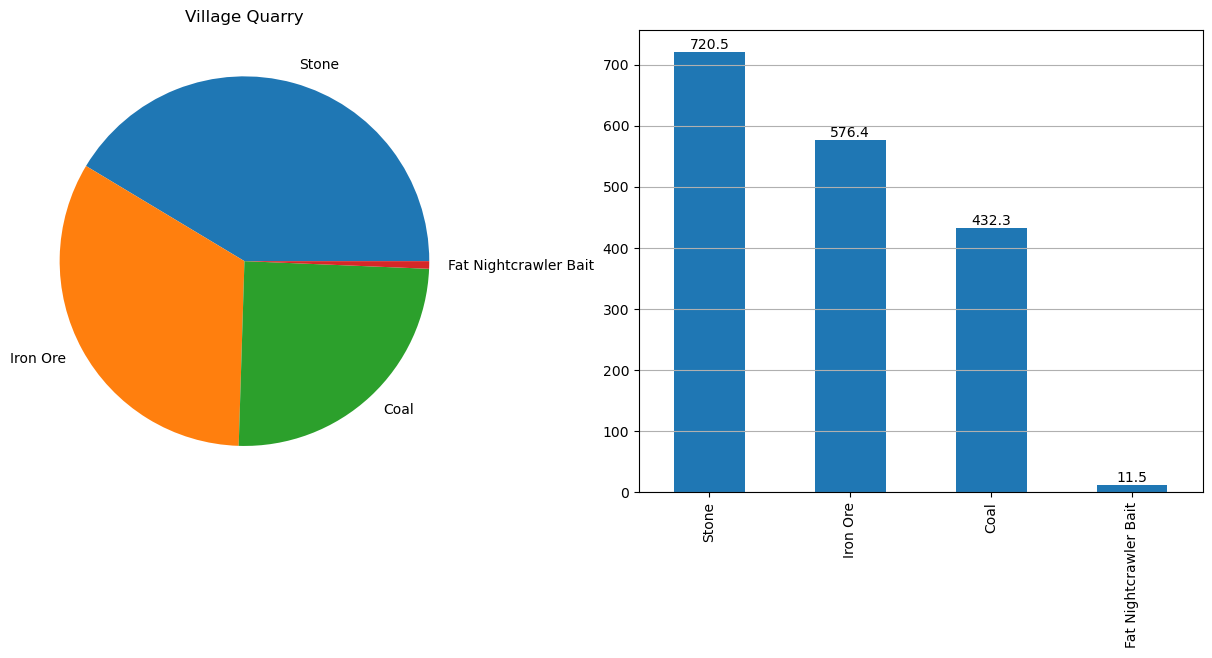

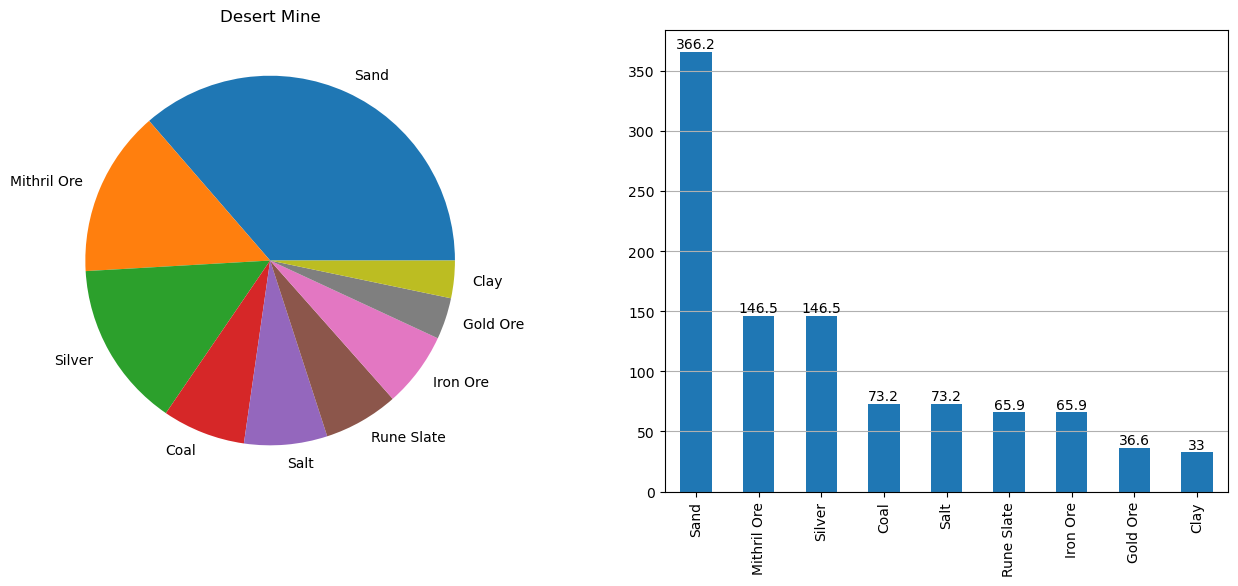

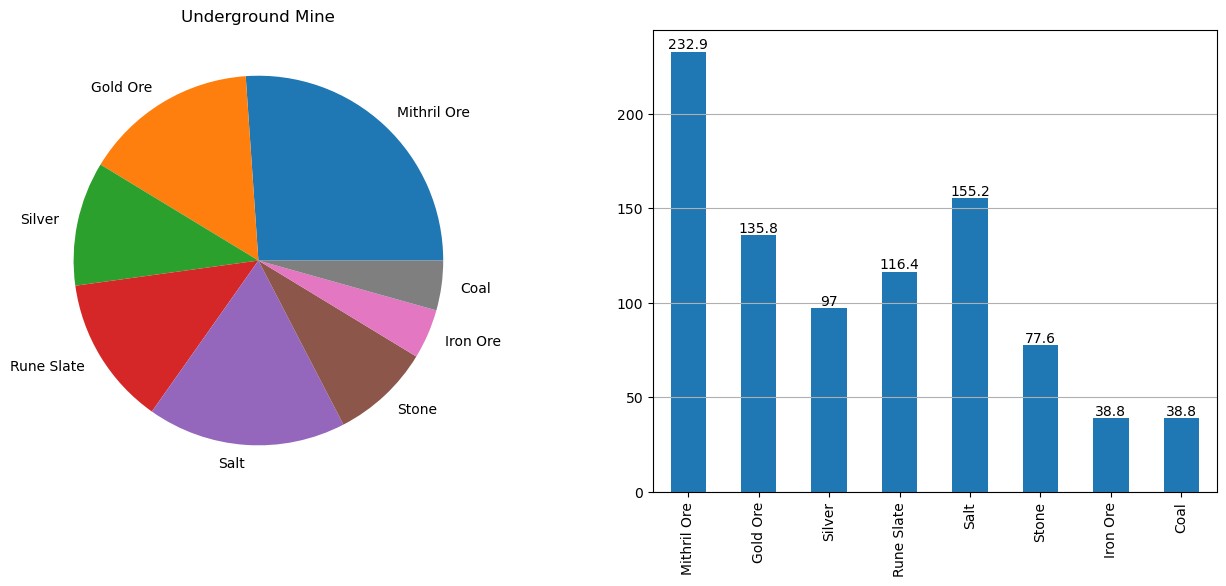

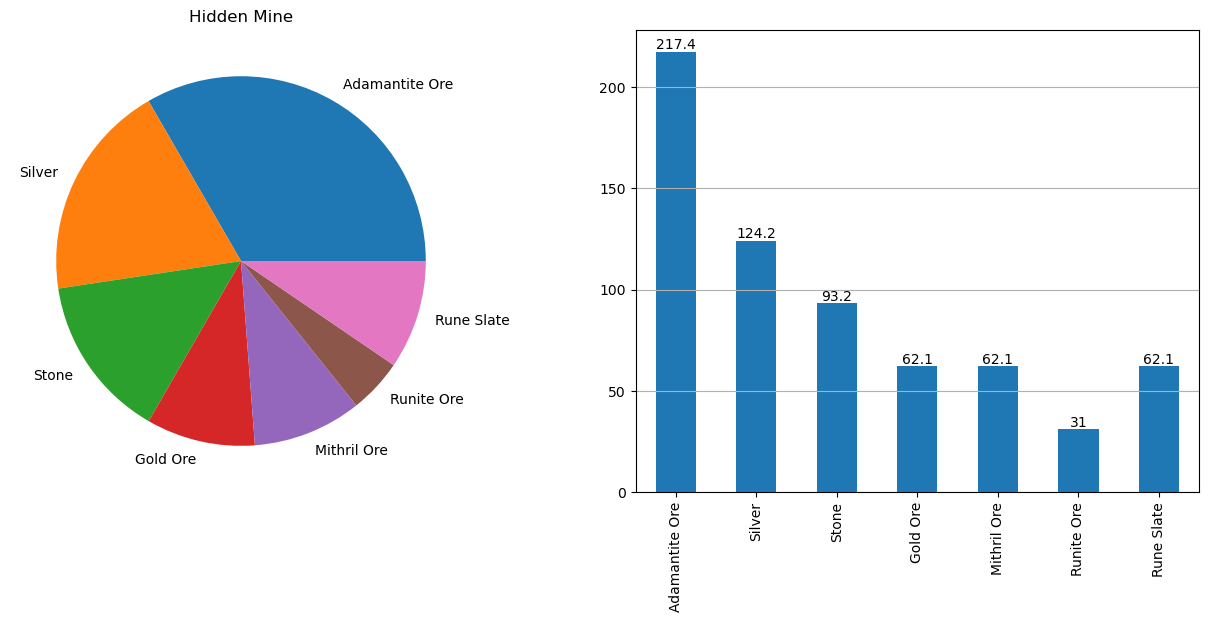

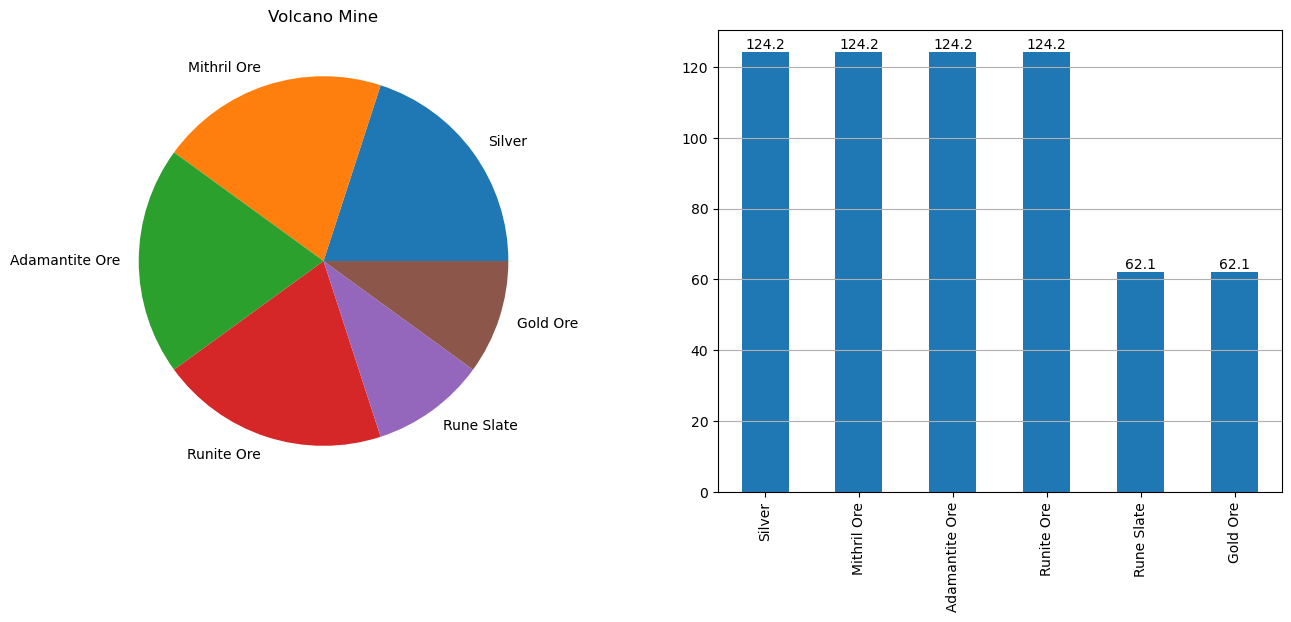

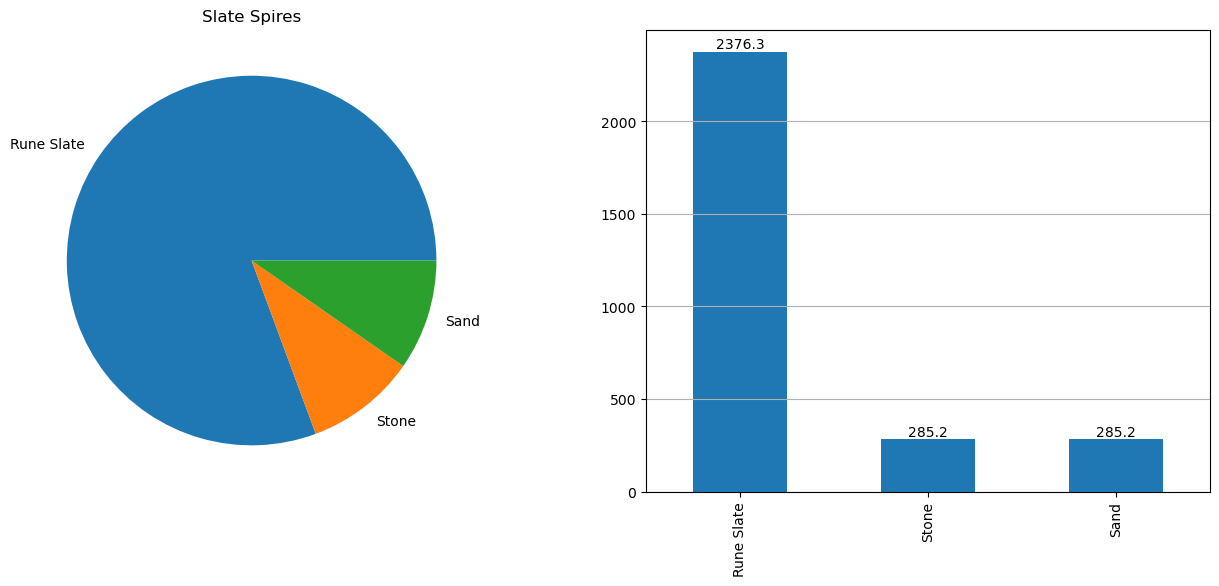

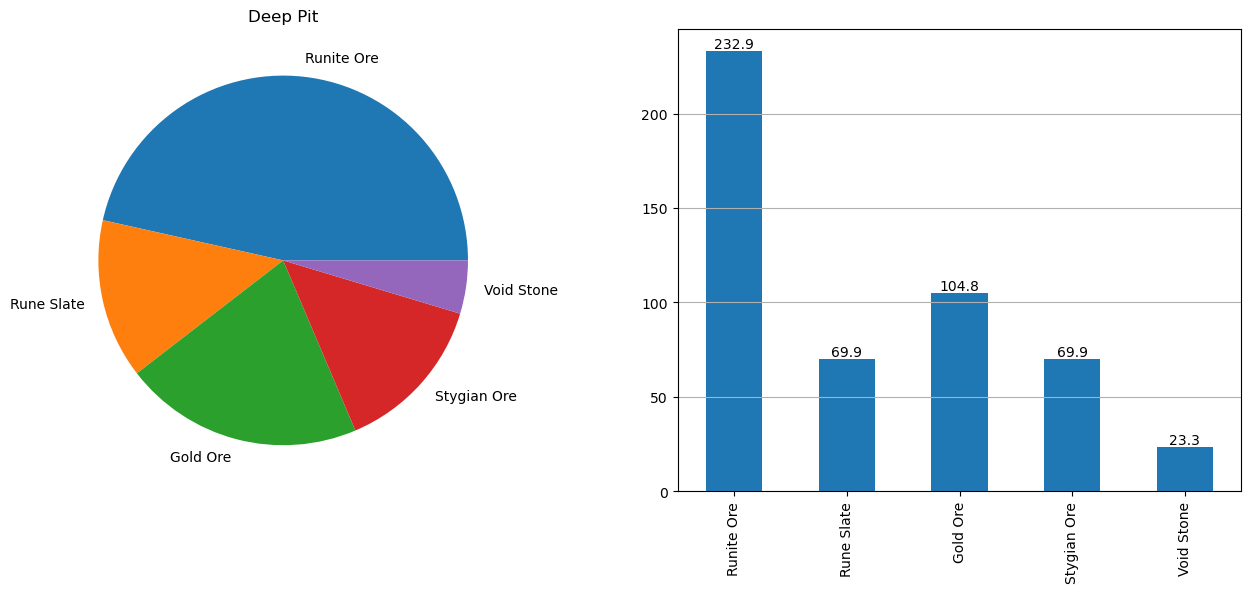

In [16]:
minno = action_summary(mining)
display(craft_summary(minno))
display(minno)